In [1]:
path = "/content/drive/MyDrive/praktikum04ml"

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    RocCurveDisplay, ConfusionMatrixDisplay
)


In [6]:
df = pd.read_csv("/content/drive/MyDrive/praktikum04ml/data/stunting_wasting_dataset.csv")
df.head()

,Jenis Kelamin,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting,Wasting
0,Laki-laki,19,91.6,13.3,Tall,Risk of Overweight
1,Laki-laki,20,77.7,8.5,Stunted,Underweight
2,Laki-laki,10,79.0,10.3,Normal,Risk of Overweight
3,Perempuan,2,50.3,8.3,Severely Stunted,Risk of Overweight
4,Perempuan,5,56.4,10.9,Severely Stunted,Risk of Overweight


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Jenis Kelamin      100000 non-null  object 
 1   Umur (bulan)       100000 non-null  int64  
 2   Tinggi Badan (cm)  100000 non-null  float64
 3   Berat Badan (kg)   100000 non-null  float64
 4   Stunting           100000 non-null  object 
 5   Wasting            100000 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 4.6+ MB


In [8]:
df.isnull().sum()

,0
Jenis Kelamin,0
Umur (bulan),0
Tinggi Badan (cm),0
Berat Badan (kg),0
Stunting,0
Wasting,0


In [9]:
df['Stunting'].unique()

array(['Tall', 'Stunted', 'Normal', 'Severely Stunted'], dtype=object)

In [10]:
df['Jenis Kelamin'].unique()

array(['Laki-laki', 'Perempuan'], dtype=object)

In [11]:
# 1. Mapping kolom Stunting -> biner
map_stunt = {'Stunted': 1, 'Severely Stunted': 1, 'Normal': 0, 'Tall': 0}
df['Stunting_bin'] = df['Stunting'].map(map_stunt).astype('Int64')

# 2. Mapping kolom Jenis Kelamin -> biner
#    Laki-laki = 1, Perempuan = 0
df['JK_bin'] = (df['Jenis Kelamin'] == 'Laki-laki').astype(int)

# Cek distribusi hasil mapping
print("Distribusi Stunting_bin:\n", df['Stunting_bin'].value_counts())
print("\nDistribusi JK_bin:\n", df['JK_bin'].value_counts())


Distribusi Stunting_bin:
 Stunting_bin
0    78021
1    21979
Name: count, dtype: Int64

Distribusi JK_bin:
 JK_bin
1    50179
0    49821
Name: count, dtype: int64


In [12]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix

,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting_bin,JK_bin
Umur (bulan),1.000000,0.875869,0.665389,0.038630,0.004046
Tinggi Badan (cm),0.875869,1.000000,0.626005,-0.283855,0.073505
Berat Badan (kg),0.665389,0.626005,1.000000,0.021090,0.045797
Stunting_bin,0.038630,-0.283855,0.021090,1.000000,-0.005981
JK_bin,0.004046,0.073505,0.045797,-0.005981,1.000000


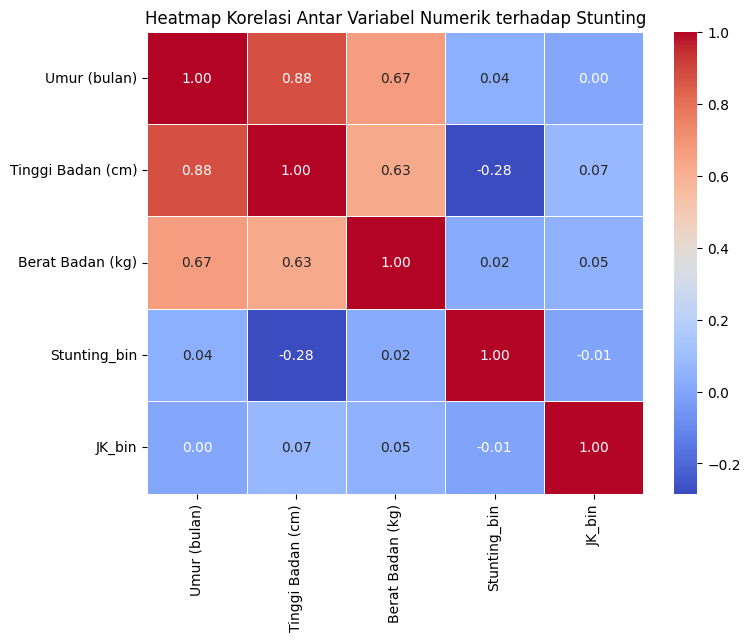

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap Korelasi Antar Variabel Numerik terhadap Stunting", fontsize=12)
plt.show()


In [18]:
feature_num = ['Umur (bulan)', 'Tinggi Badan (cm)', 'Berat Badan (kg)']
feature_bin = ['JK_bin']

use_cols = feature_num + feature_bin + ['Stunting_bin']
df_model = df[use_cols].dropna().copy()

x = df_model[feature_num + feature_bin]
y = df_model['Stunting_bin']

print("x shape:", x.shape)
print("y shape:", y.shape)

x shape: (100000, 4)
y shape: (100000,)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(x, y,
test_size=0.2,
random_state=42,
stratify=y
)

print("Data latih:", X_train.shape, y_train.shape)
print("Data uji:", X_test.shape, y_test.shape)

Data latih: (80000, 4) (80000,)
Data uji: (20000, 4) (20000,)


In [22]:
# Impor semua pustaka/modul yang dibutuhkan
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Asumsikan feature_num, feature_bin, X_train, dan y_train sudah didefinisikan sebelumnya

# Scale hanya fitur numerik, gender Langsung passthrough
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), feature_num),
        ('bin', 'passthrough', feature_bin)
    ],
    remainder='drop'
)

model = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    class_weight='balanced',
    random_state=42
)

clf = Pipeline([
    ('preprocess', preprocess),
    ('model', model)
])

# Latih model
clf.fit(X_train, y_train)
print("✅ Model Logistic Regression berhasil dilatih.")

✅ Model Logistic Regression berhasil dilatih.


In [24]:
# Prediksi & probabilitas
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Hitung metrik
print(f"Akurasi    : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision  : {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"Recall     : {recall_score(y_test, y_pred, zero_division=0):.4f}")
print(f"F1-Score   : {f1_score(y_test, y_pred, zero_division=0):.4f}")
print(f"ROC-AUC    : {roc_auc_score(y_test, y_prob):.4f}")

Akurasi    : 0.9055
Precision  : 0.7152
Recall     : 0.9472
F1-Score   : 0.8150
ROC-AUC    : 0.9656


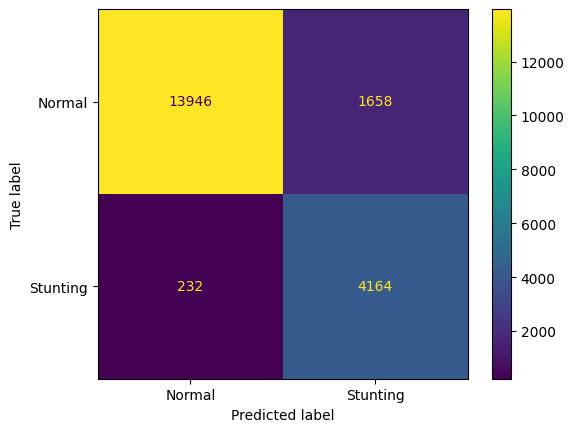

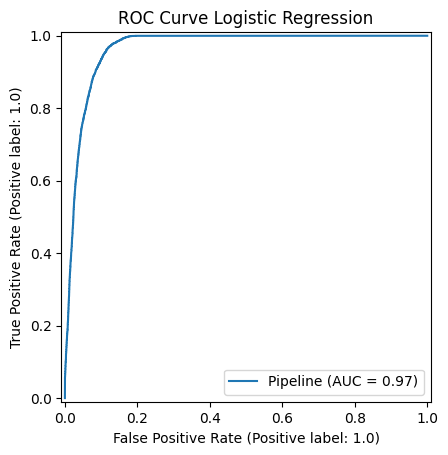

In [26]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred),display_labels=['Normal', 'Stunting']
).plot(values_format='d')
plt.show()

RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("ROC Curve Logistic Regression")
plt.show()

In [29]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=['Tidak Stunting (0)', 'Stunting (1)']))


                    precision    recall  f1-score   support

Tidak Stunting (0)       0.98      0.89      0.94     15604
      Stunting (1)       0.72      0.95      0.82      4396

          accuracy                           0.91     20000
         macro avg       0.85      0.92      0.88     20000
      weighted avg       0.92      0.91      0.91     20000



In [33]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf,x,y, cv=5)

print("Skor tiap fold:", scores)
print("Rata-rata akurasi:", np.mean(scores))
print("Standar deviasi:", np.std(scores))

Skor tiap fold: [0.9062  0.9013  0.9052  0.89905 0.9002 ]
Rata-rata akurasi: 0.9023899999999999
Standar deviasi: 0.0028125433329995106


In [36]:
feat_names = feature_num + feature_bin
coefs = clf.named_steps['model'].coef_[0]
odds = np.exp(coefs)

coef_df = pd.DataFrame({
    'Feature': feat_names,
    'Koefisien (log-odds)': coefs,
    'Odds Ratio (e^coef)': odds
}).sort_values('Odds Ratio (e^coef)', ascending=False)

display(coef_df)

,Feature,Koefisien (log-odds),Odds Ratio (e^coef)
0,Umur (bulan),8.525912,5043.782458
3,JK_bin,1.675944,5.343839
2,Berat Badan (kg),0.661090,1.936903
1,Tinggi Badan (cm),-10.535980,0.000027


In [43]:
# Contoh 2 anak
data_baru = pd.DataFrame({
    'Umur (bulan)': [24, 10],
    'Tinggi Badan (cm)': [79.0, 72.5],
    'Berat Badan (kg)': [9.2, 7.8],
    'JK_bin': [1, 0]   # 1=Laki-Laki, 0=Perempuan
})

pred = clf.predict(data_baru)
prob = clf.predict_proba(data_baru)[:,1]

hasil = data_baru.copy()
hasil['Prob_Stunting'] = prob
hasil['Pred (0=Tidak,1=Ya)'] = pred
display(hasil)


,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),JK_bin,Prob_Stunting,"Pred (0=Tidak,1=Ya)"
0,24,79.0,9.2,1,0.998208,1.0
1,10,72.5,7.8,0,0.002094,0.0
